In [1]:
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az
import pandas as pd
%matplotlib inline
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

In [2]:
def build_B_spline_deg_zero_degree_basis_fns(breaks, x):
    """Build B spline 0 order basis coefficients with knots at 'breaks'. 
    N_{i,0}(x) = { 1 if u_i <= x < u_{i+1}, 0 otherwise }
    """
    expr = []
    expr.append(tt.switch(x<breaks[1], 1, 0))
    for i in range(1, len(breaks)-2):
        l_break = breaks[i]
        u_break = breaks[i+1]
        expr.append(
            tt.switch((x>=l_break)&(x<u_break), 1, 0) )
    expr.append( tt.switch(x>=breaks[-2], 1, 0) )
    return expr

In [3]:
def build_B_spline_higher_degree_basis_fns(
        breaks, prev_degree_coefs, degree, x):
    """Build the higer order B spline basis coefficients
    N_{i,p}(x) = ((x-u_i)/(u_{i+p}-u_i))N_{i,p-1}(x) \
               + ((u_{i+p+1}-x)/(u_{i+p+1}-u_{i+1}))N_{i+1,p-1}(x)
    """
    assert degree > 0
    coefs = []
    for i in range(len(prev_degree_coefs)-1):
        alpha1 = (x-breaks[i])/(breaks[i+degree]-breaks[i]+1e-12)
        alpha2 = (breaks[i+degree+1]-x)/(breaks[i+degree+1]-breaks[i+1]+1e-12)
        coef = alpha1*prev_degree_coefs[i] + alpha2*prev_degree_coefs[i+1]
        coefs.append(coef)
    return coefs

In [4]:
def build_B_spline_basis_fns(breaks, max_degree, x):
    curr_basis_coefs = build_B_spline_deg_zero_degree_basis_fns(breaks, x)
    for degree in range(1, max_degree+1):
        curr_basis_coefs = build_B_spline_higher_degree_basis_fns(
            breaks, curr_basis_coefs, degree, x)
    return curr_basis_coefs

In [5]:
def spline_fn_expr(breaks, intercepts, degree, x):
    basis_fns = build_B_spline_basis_fns(breaks, degree, x)
    spline = 0
    for i, basis in enumerate(basis_fns):
        spline += intercepts[i]*basis
    return spline

In [6]:
def compile_spline(data,n_bins,degree,intercepts):
    breaks = np.histogram(data, n_bins)[1][1:-1]
    for i in range(degree+1):
        breaks = np.insert(breaks, 0, data.min()-1e-6)
        breaks = np.append(breaks, data.max()+1e-6)
    xs = tt.vector(dtype=theano.config.floatX)
    f = theano.function([intercepts, xs],spline_fn_expr(breaks, intercepts, degree, xs))
    return f

In [7]:
filtered = pd.read_csv('../data/filtered.csv')
filtered = filtered[filtered["REGISTRATION_ID"] < 2]
pred_var = "ESM_BLOAT2"
filtered = filtered[["ESM_ABDPAIN",pred_var]]
#filtered = filtered[filtered["ESM_ABDPAIN"]> 0]
filtered.dropna(inplace=True)
x = filtered[pred_var].to_numpy()
domain = np.sort(x)
print(x)

[9. 7. 6. ... 3. 3. 0.]


In [8]:
n_bins = 5
degree = 3
num_coef = n_bins + degree + 1 # Restraint that must be obeyed by parameter sets of B-splines
coefficients = tt.vector(dtype=theano.config.floatX)
spline = compile_spline(domain,n_bins,degree,coefficients)
y_noisy = filtered['ESM_ABDPAIN'].to_numpy()

In [9]:
breaks = np.histogram(domain, n_bins)[1][1:-1]
for i in range(degree+1):
    breaks = np.insert(breaks, 0, domain.min()-1e-6)
    breaks = np.append(breaks, domain.max()+1e-6)

In [10]:
with pm.Model() as model:   
    coef   = pm.Flat('coef',shape = num_coef,testval = np.zeros(num_coef))
    x_as_tensor = tt.as_tensor(x)
    s = spline_fn_expr(breaks, coef, degree, x_as_tensor)

In [11]:
n_samples=200
with model:
    sigma  = pm.HalfCauchy('sigma',beta=0.5)
    y_hat  = pm.Deterministic('y_hat',s)
    y      = pm.Normal('y',mu = y_hat,sd = sigma,observed = y_noisy)
    trace  = pm.sample(n_init=1, draws=n_samples)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, coef]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:27<00:00, 51.47draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
T = len(domain)
function_samples= np.zeros([T,n_samples])
for i in range(n_samples):
    coef_sample = trace['coef'][i,:]
    function_samples[:,i] = spline(coef_sample,domain)
    
ci = np.percentile(function_samples,[95,50,5],axis = 1)

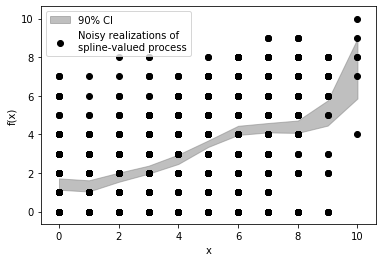

In [13]:
plt.fill_between(domain,ci[0],ci[2],color='0.5',alpha = 0.5,label = '90% CI')
plt.scatter(x,y_noisy,label = 'Noisy realizations of \nspline-valued process',color='k');
#plt.plot(domain,true_mean,color='k',label = 'True function value')
plt.legend(loc = 'upper left');
plt.xlabel('x');
plt.ylabel('f(x)');
#plt.savefig('spline_ci',dpi = 400)

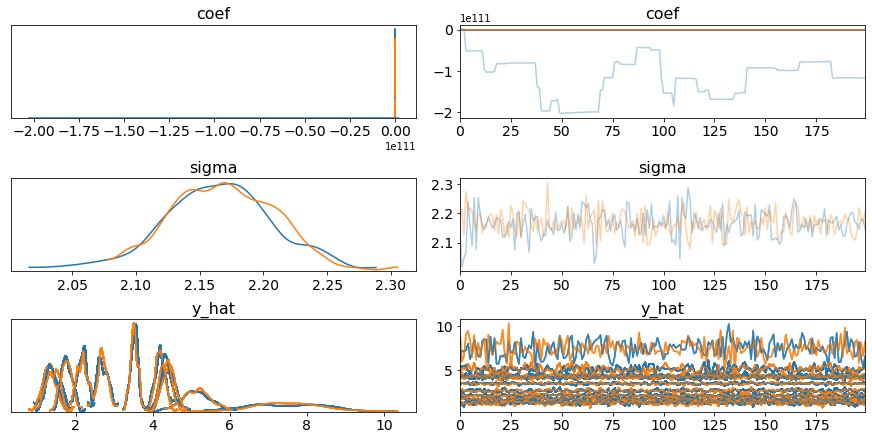

In [14]:
az.plot_trace(trace, compact=True);